In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine,reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB

session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [12]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [13]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
print(calc_temps('2017-08-01','2017-08-07'))

[(72.0, 79.25, 83.0)]


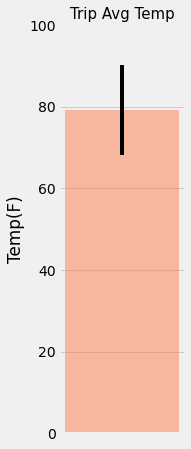

In [30]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

data = calc_temps('2017-08-01','2017-08-07')

y = data[0][1]
error = data[0][2] - data[0][0]
x = 1
plt.figure(figsize=(2,7))
plt.bar(x,y,yerr=error,color='coral',align='center',alpha=0.5);
plt.xticks([])
plt.ylim(0,100)
plt.ylabel('Temp(F)')
plt.title('Trip Avg Temp',fontsize=15)

plt.grid(b=True, which='both')

### Daily Rainfall Average

In [35]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

col_list = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation,
            func.sum(Measurement.prcp)]
startdate = dt.date(2017,8,1) - dt.timedelta(days=365)
enddate = startdate + dt.timedelta(days=6)

data_rainfall = session.query(*col_list).filter(Station.station == Measurement.station).\
                filter(Measurement.date>=startdate).\
                filter(Measurement.date<=enddate).\
                group_by(Station.station).\
                order_by(func.sum(Measurement.prcp).desc()).all()

df_rainfall = pd.DataFrame(data_rainfall,columns=['Station','Name','Lat','Lon','Ele','PrcpSum'])

df_rainfall

,Station,Name,Lat,Lon,Ele,PrcpSum
0,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,6.02
1,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,4.65
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,3.59
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,1.30
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,1.03
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.57
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.18


In [36]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [55]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []
# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
days = []

startdate = dt.datetime.strptime(start_date,'%Y-%m-%d')
enddate = dt.datetime.strptime(end_date,'%Y-%m-%d')
delta = dt.timedelta(days=1)

while startdate<=enddate:
    days.append(startdate.strftime("%m-%d"))
    startdate += delta
    
# Strip off the year and save a list of strings in the format %m-%d


# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.

for date in days:
    normals.append(daily_normals(date))

normals

[[(67.0, 75.54, 83.0)],
 [(68.0, 75.60377358490567, 84.0)],
 [(70.0, 76.61111111111111, 85.0)],
 [(69.0, 76.71153846153847, 84.0)],
 [(69.0, 76.14814814814815, 82.0)],
 [(67.0, 76.25, 83.0)],
 [(71.0, 77.15686274509804, 83.0)]]

In [89]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
Tmin_list=[]
Tavg_list=[]
Tmax_list=[]

for group in normals:
    Tmin_list.append(group[0][0])
    Tavg_list.append(group[0][1])
    Tmax_list.append(group[0][2])

   
    
df_temp = pd.DataFrame({'Date':days,'TempMin':Tmin_list,'TempAvg':Tavg_list,'TempMax':Tmax_list})

df_temp.set_index('Date',inplace=True)

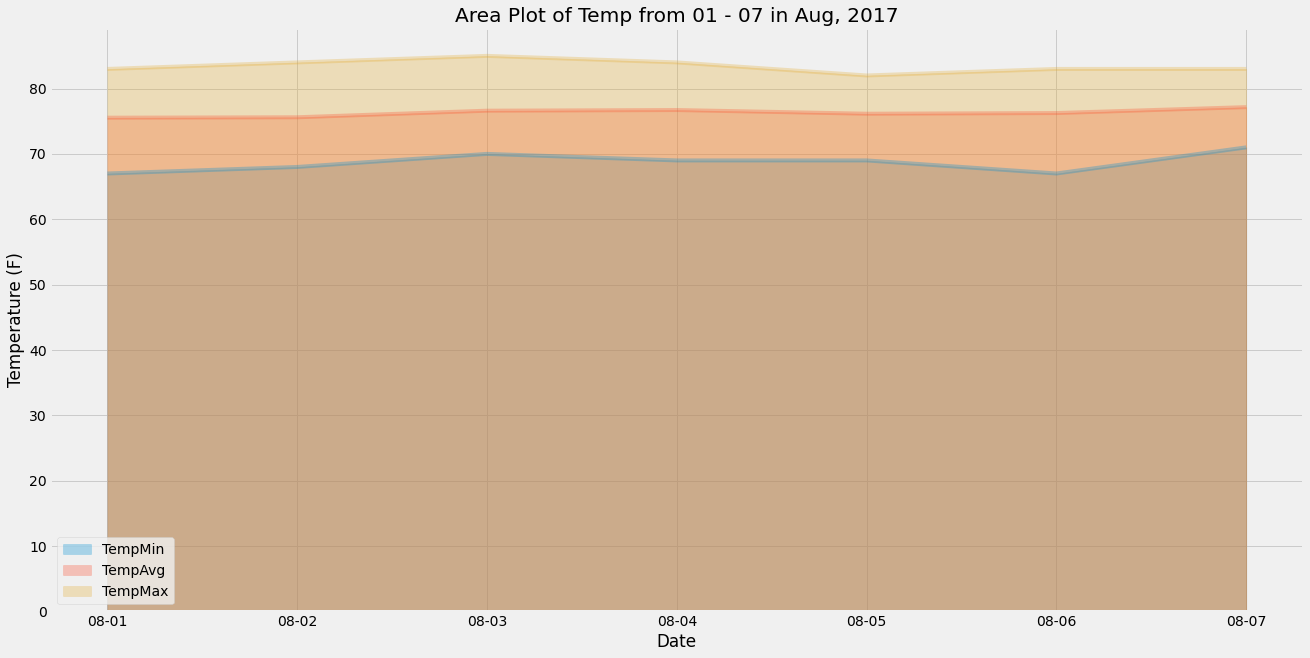

In [91]:
# Plot the daily normals as an area plot with `stacked=False`

df_plot = df_temp.plot.area(stacked=False, alpha=0.3,figsize=(20,10))


plt.title('Area Plot of Temp from 01 - 07 in Aug, 2017')
plt.ylabel('Temperature (F)')
plt.xlabel('Date')
plt.show()


## Conclusion

Base on the are plot, it is fair to say that the temperature during these 7 days in the year of 2017 are stable and it is around 75F, which is about 23C.

## Close Session

In [92]:
session.close()